In [48]:
# Imports
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
import matplotlib.pyplot as plt
torch.cuda.empty_cache()

from CustomCNN import CustomCNN

In [49]:
data_easy = torch.load('./data/CustomDataset/easier.pth')
data_harder = torch.load('./data/CustomDataset/harder.pth')
data_vary_disk = torch.load('./data/CustomDataset/vary_disk.pth')

images = torch.cat((data_easy['images'],
                    data_harder['images'],
                    data_vary_disk['images']))

images = images.float()
labels = torch.cat((data_easy['labels'],
                    data_harder['labels'],
                    data_vary_disk['labels']))

In [50]:
# Create dataset
dataset = TensorDataset(images.unsqueeze(1), labels)  # Add channel dimension

# Split dataset: 80% for training and 20% for validation/testing
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [51]:
# Placeholders for metrics
train_losses = []
test_losses = []
test_accuracies = []

In [52]:
# Loss Function and Optimizer
model = CustomCNN(chanels=32, kernel_size=3).cuda()  # .cuda() if using GPU
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):

    model.train() 
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()  # .cuda() if using GPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:  # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0
    
    # Calculate training loss for this epoch
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validate the model
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    test_accuracy = 100 * correct / total
    test_accuracies.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f} Test Loss: {avg_test_loss:.4f} Test Accuracy: {test_accuracy:.2f}%')

Epoch [1/5] Train Loss: 0.2811 Test Loss: 0.0482 Test Accuracy: 99.17%
Epoch [2/5] Train Loss: 0.0272 Test Loss: 0.0051 Test Accuracy: 100.00%
Epoch [3/5] Train Loss: 0.0112 Test Loss: 0.0010 Test Accuracy: 100.00%
Epoch [4/5] Train Loss: 0.0012 Test Loss: 0.0003 Test Accuracy: 100.00%
Epoch [5/5] Train Loss: 0.0007 Test Loss: 0.0003 Test Accuracy: 100.00%


In [53]:
# Saving model
torch.save(model.state_dict(), './Models/custom_cnn_custom_dataset.pth')

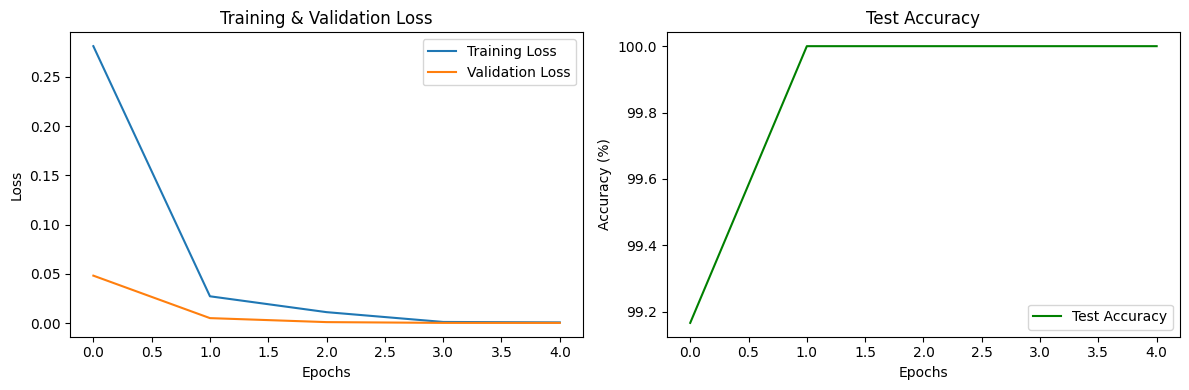

In [54]:
# 4. Plotting metrics
plt.figure(figsize=(12, 4))

# Training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
_ = plt.legend()

# Test accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
_ = plt.legend()

_ = plt.tight_layout()
_ = plt.show()

In [55]:
# Optional: Test the network on the test data
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()  # .cuda() if using GPU
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 100 %
